In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn import preprocessing
import category_encoders as ce

In [274]:
df = pd.read_csv('data/ds_salaries.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


In [275]:
print(f"Duplicates found: {df[df.duplicated()].shape[0]}")
print(f"DataFrame shape before deduplication: {df.shape}")
df = df.drop_duplicates()
print(f"DataFrame shape after deduplication: {df.shape}")


Duplicates found: 42
DataFrame shape before deduplication: (607, 11)
DataFrame shape after deduplication: (565, 11)


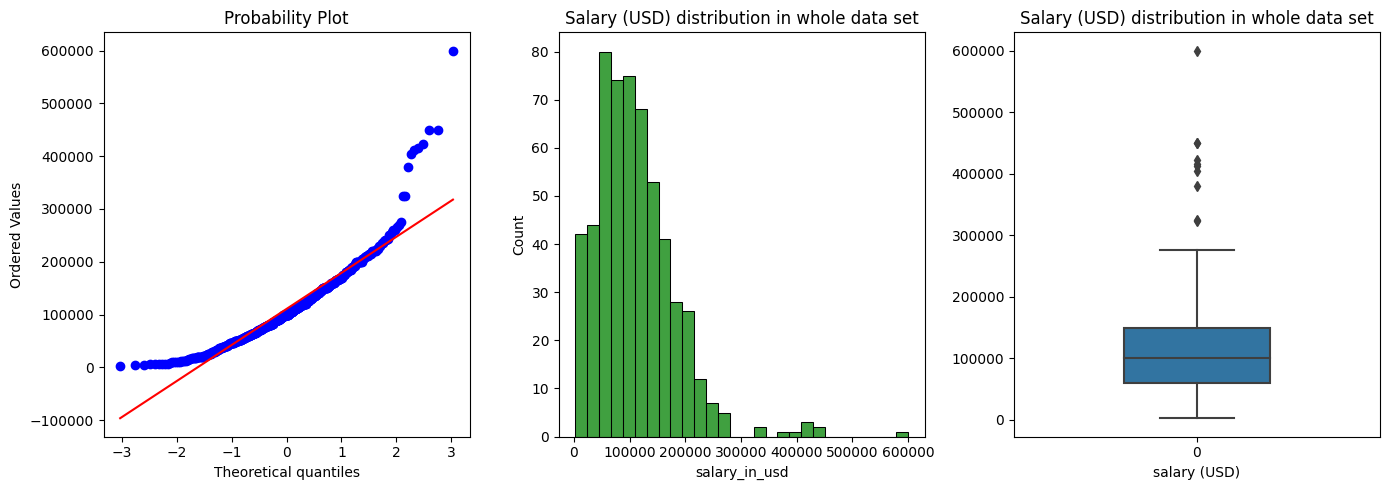

In [276]:
# let's analyse the main feature of the current investigation 'salary_in_usd'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

plt.subplot(1, 3, 1) 
stats.probplot(df['salary_in_usd'], plot=plt) 

plt.subplot(1, 3, 2) 
sal_h = sns.histplot(df['salary_in_usd'], color='g') 
sal_h.set_title('Salary (USD) distribution in whole data set')

plt.subplot(1, 3, 3) 
sal_b = sns.boxplot(df['salary_in_usd'], width=0.4) 
sal_b.set_title('Salary (USD) distribution in whole data set')
sal_b.set_xlabel('salary (USD)')

plt.tight_layout()

plt.show()

In [277]:
df['salary_in_usd'].describe().round(2).to_frame()

,salary_in_usd
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


In [278]:
# set alpha
alpha = 0.05 

# Shapiro test for normality
_, p = stats.shapiro(df['salary_in_usd'])

print('p-value = %.2f' % (p))

# show test result
if p <= alpha:
    print('Salary distribution is NOT NORMAL')
else:
    print('Salary distribution is NORMAL')

p-value = 0.00
Salary distribution is NOT NORMAL


    1) Изучаемая выборка содержит 607 строк, 42 из них продублированы, пропуски отсутствуют. 
    2) 4 признака числовые (int64), 7 - object
    3) Основной изучаемый признак 'salary_in_usd' имеет распределение отличное от нормального 


=================================================================================================================================================
## Предварительный анализ факторов, влияющих на зарплату специалистов DS

### Зависимость заработной платы от опыта

In [279]:
# group by experience w aggregation by median salary and qty
df_exp = df.groupby(['experience_level'])['salary_in_usd'].agg(median_salary='median', positions_qty='count')
df_exp['median_salary / positions_qty'] = (df_exp['median_salary'] / df_exp['positions_qty']).round(1)
df_exp.sort_values(by='median_salary / positions_qty', ascending=False)

,median_salary,positions_qty,median_salary / positions_qty
experience_level,,,
EX,171437.5,26,6593.8
EN,56500.0,88,642.0
SE,135000.0,243,555.6
MI,76940.0,208,369.9


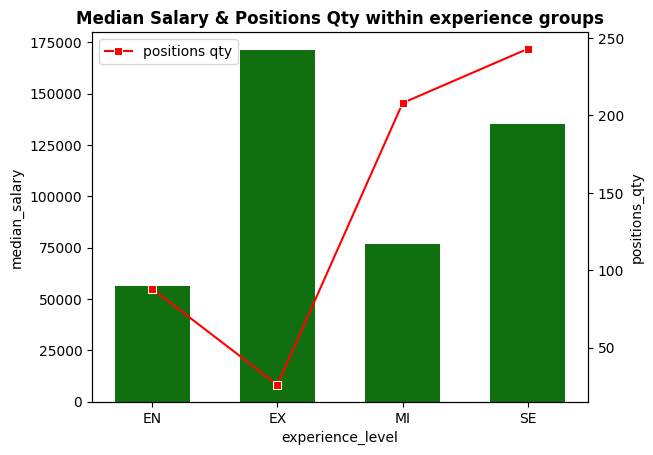

In [280]:
exp_sal = sns.barplot(
    df_exp,
    x=df_exp.index,
    y='median_salary',
    orient='v',
    width=.6,
    color='g'
)

ax2=plt.twinx()

sns.lineplot(
    df_exp,
    x=df_exp.index,
    y='positions_qty',
    color='r',
    ax=ax2,
    label='positions qty',
    marker='s'
)

plt.legend(loc='best')
exp_sal.set_title('Median Salary & Positions Qty within experience groups', fontweight='bold')
plt.show()
             

    1) судя по визуализации, наблюдается прямая зависимость медианной з/п от опыта
    2) интересно соотношение уровня з/п к количеству соответствующих позиций: для группы 'Executive' оно на порядок выше по сравнению с остальными, что говорит о крайней востребованности специалистов этой группы

### Зависимость з/п от объема удаленной работы в ТОР10 стран проживания 

Rate of employee living in TOP10 'employee residences': 84.4


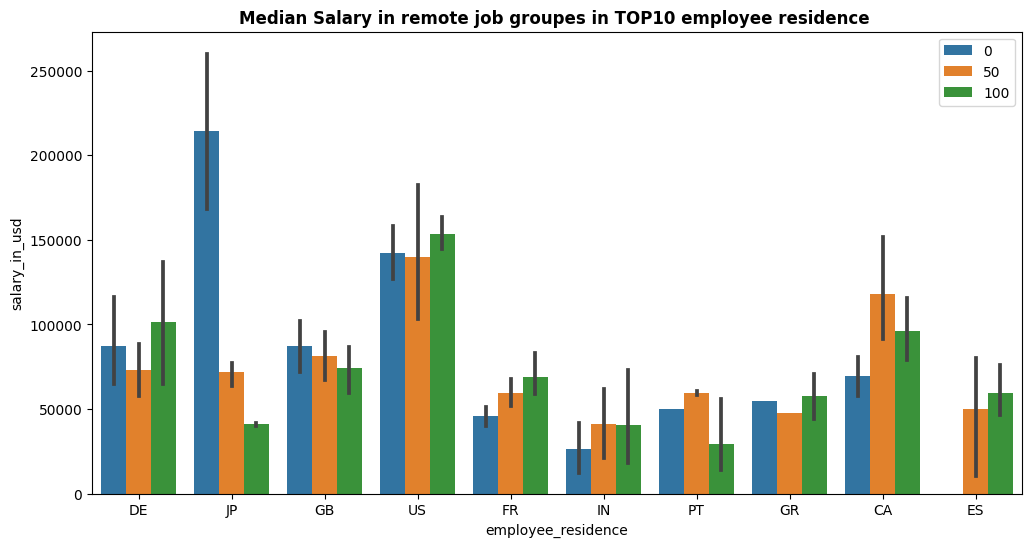

In [281]:
# list of TOP10 residence locations according to the largest value counts
lst = list(df['employee_residence'].value_counts().nlargest(10).index)
print(f"Rate of employee living in TOP10 'employee residences': {(df['employee_residence'].value_counts().nlargest(10).sum() * 100 / df['employee_residence'] .value_counts().sum()).round(1)}")

f,a = plt.subplots(figsize=(12,6))
residence_bar = sns.barplot(
    df[df['employee_residence'].isin(lst)],
    x='employee_residence',
    y='salary_in_usd',
    hue='remote_ratio',
    
);

residence_bar.set_title('Median Salary in remote job groupes in TOP10 employee residence ', fontweight='bold')
plt.legend(loc='upper right');

    1) абсолютный лидер по уровню з/п во всех категориях удаленной работы - US
    2) единственная страна из ТОР10, где отстутствует категория 'удаленной работы нет' - ES
    3) абсолютный лидер по уровню з/п в категории 'удаленной работы нет' - JP

### Зависимость з/п от типа трудоустройства

In [282]:
(df['employment_type'].value_counts(normalize=True)*100).round(1)

employment_type
FT    96.6
PT     1.8
CT     0.9
FL     0.7
Name: proportion, dtype: float64

    1) можно исключить из анализа, т.к. 96.6% выборки сосредоточена в категории 'full time'

### Количество уникальных позиций и уровень з/п в компаниях различного размера

Unique positions at dataset: 50


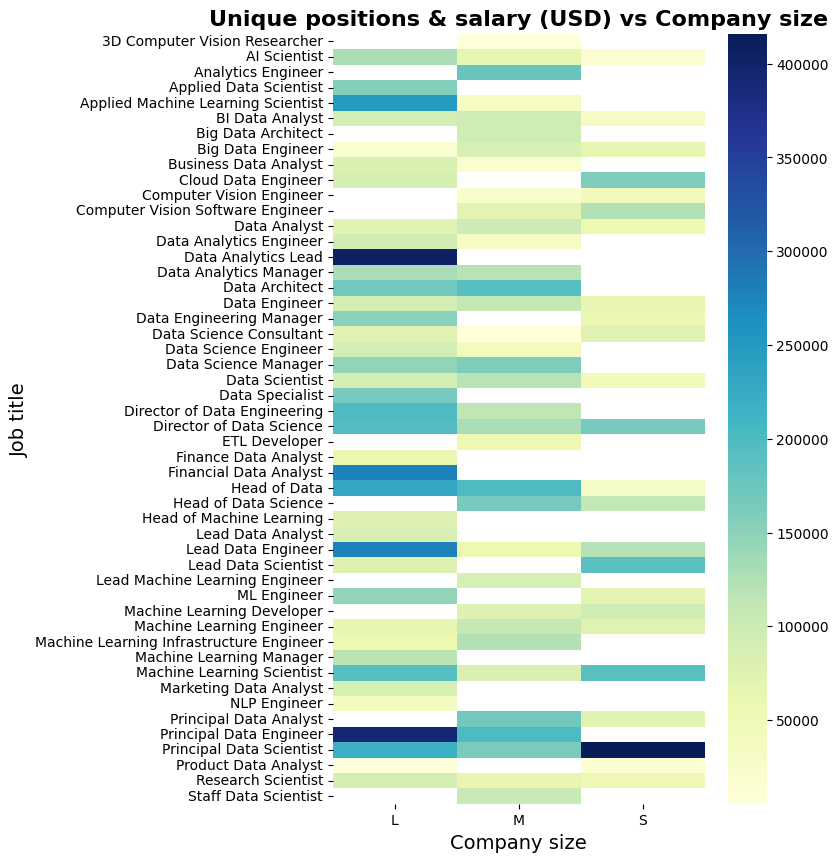

In [283]:
pivot2 = df.pivot_table(
    values='salary_in_usd',
    columns='company_size',
    index='job_title',
    aggfunc='median'
)

f,a = plt.subplots(figsize=(6,10))
heatmap = sns.heatmap(data=pivot2, cmap='YlGnBu')
heatmap.set_title('Unique positions & salary (USD) vs Company size', fontsize=16, fontweight='bold');
heatmap.set_ylabel('Job title', fontsize=14)
heatmap.set_xlabel('Company size', fontsize=14);

print(f"Unique positions at dataset: {df['job_title'].nunique()}")


    1) Наибольшее количество уникальных позиций специалистов DS сосредоточено в компаниях категории 'Large'
    2) прослеживается тенденция роста медианной з/п количества уникальных позиций с увеличением размера компании
    3) наибольший уровень медианной з/п наблюдается у специалистов 'Principal Data Engineer', 'Principal Data Scientist', 'Data Analytics Lead'

### Уровень медианной з/п в зависимости от локализации главного офиса (ТОР20), в разные годы

Text(162.72222222222223, 0.5, 'Salary (USD)')

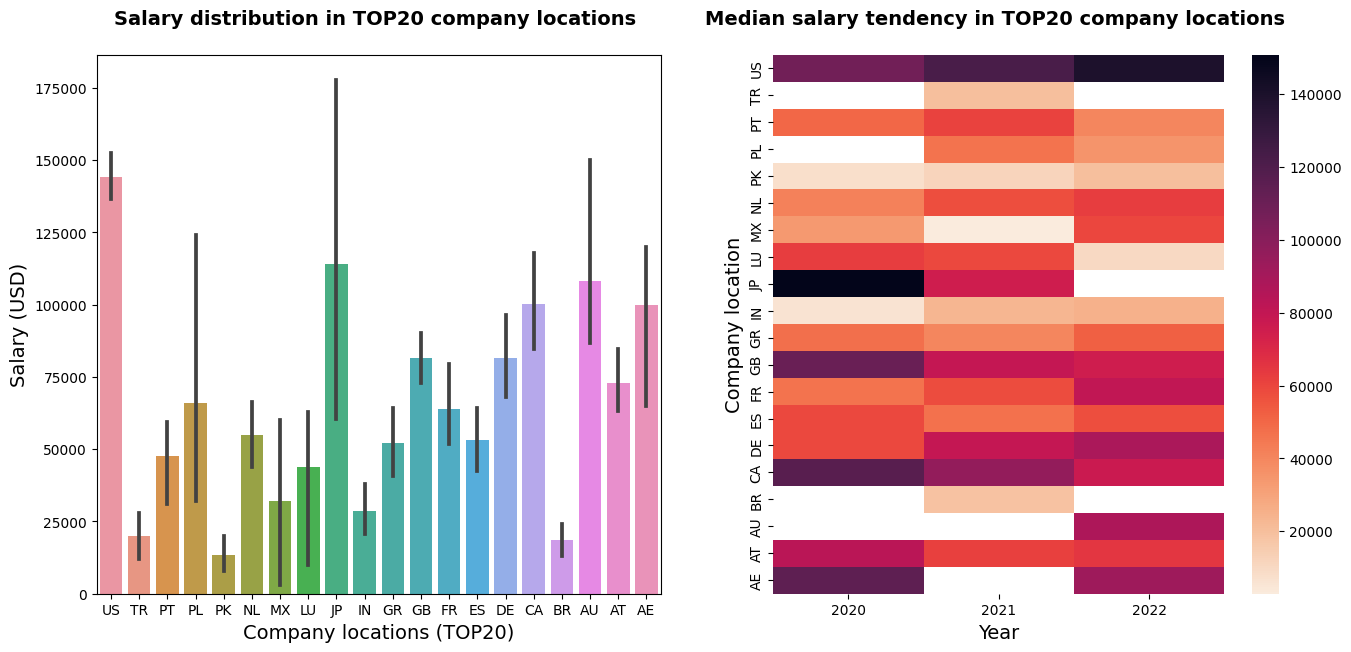

In [284]:
# list TOP20 company locations according to the largest value counts 
lst = list(df['company_location'].value_counts().nlargest(20).index)

pivot3 = df[df['company_location'].isin(lst)].pivot_table(
    values='salary_in_usd',
    columns='work_year',
    index='company_location',
    aggfunc='median'
).sort_values(by=['company_location'], ascending=False)

f,a = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

salary_hm = sns.heatmap(data=pivot3, cmap='rocket_r', ax=a[1])
salary_hm.set_title('Median salary tendency in TOP20 company locations \n', fontsize=14, fontweight='bold');
salary_hm.set_ylabel('Company location', fontsize=14)
salary_hm.set_xlabel('Year', fontsize=14);

salary_bar = sns.barplot(
    df[df['company_location'].isin(lst)].sort_values(by=['company_location'], ascending=False),
    x='company_location',
    y='salary_in_usd',
    ax=a[0]
)
salary_bar.set_title('Salary distribution in TOP20 company locations \n', fontsize=14, fontweight='bold')
salary_bar.set_xlabel('Company locations (TOP20)', fontsize=14)
salary_bar.set_ylabel('Salary (USD)', fontsize=14)


    1) абсолютный лидер по уровню и положительной динамике з/п - US. 
    2) US характеризует высокая предсказуемость уровня з/п (небольшой межквартильный размах)
    3) группа стран с положительной динамикой роста з/п в период 2020-2022: US, NL, FR, DE
    4) группа стран с отрицательной динамикой роста з/п в период 2020-2022: JP, LU, GB, CA, AT. AE

### Ежегодный рост зарплат у специалистов Data Scientist

In [285]:
df[df['job_title'] == 'Data Scientist'].groupby('work_year')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.523810,81436.648711,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.772727,45843.815005,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.938462,55785.243200,18442.0,95550.00,135000.0,170000.00,260000.0


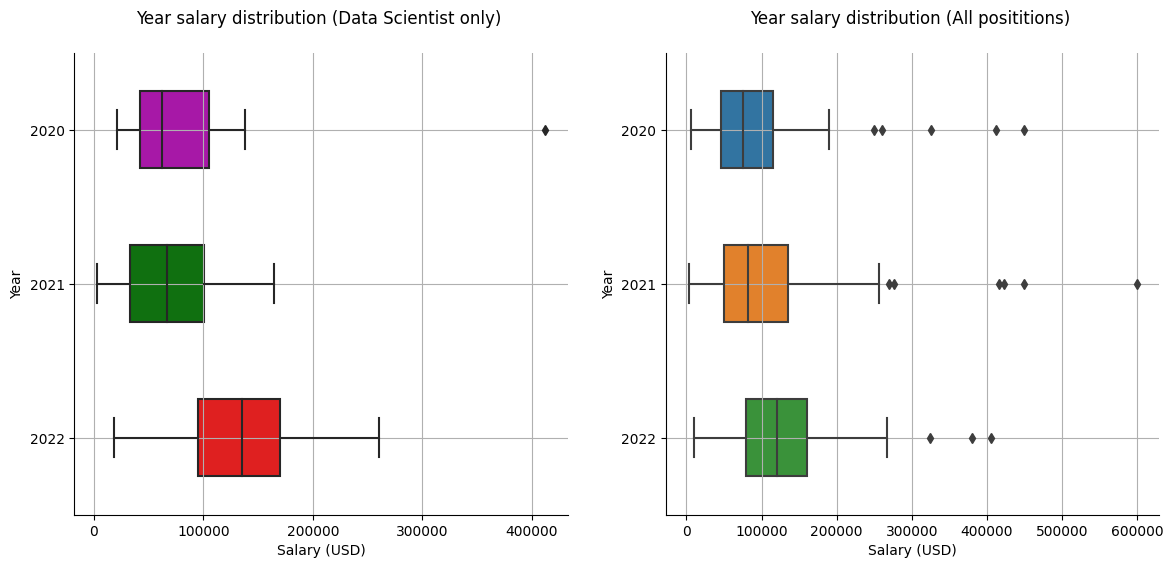

In [286]:
f,a = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ds_year_salary = sns.boxplot(df[df['job_title'] == 'Data Scientist'], y='work_year', x='salary_in_usd', orient='h', ax=a[0], palette=['m','g','r'], width=.5)
ds_year_salary.set_title('Year salary distribution (Data Scientist only) \n');
ds_year_salary.set_xlabel('Salary (USD)');
ds_year_salary.set_ylabel('Year');
ds_year_salary.grid()

all_year_salary = sns.boxplot(df, y='work_year', x='salary_in_usd', orient='h', ax=a[1], width=.5)
all_year_salary.set_title('Year salary distribution (All posititions) \n');
all_year_salary.set_xlabel('Salary (USD)');
all_year_salary.set_ylabel('Year');
all_year_salary.grid()
sns.despine(top=True, right=True, left=False)

    1) По выборке в целом наблюдается рост медианной з/п в период 2020-2022гг. Такая же динамика прослеживается для позиции Data Scientist
    2) рост медианной з/п для Data Scientist особенно выражен в 2022, в т.ч. по сравнению со всей выборкой

### Соотношение зарплат Data Scientist и Data Engineer в 2022 году

In [287]:
df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer') & (df['work_year'] == 2022)].groupby('job_title')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,79.0,124651.78,57846.84,25000.0,78526.00,115000.0,160040.0,324000.0
Data Scientist,130.0,103336.35,63967.56,2859.0,50330.25,100000.0,140400.0,412000.0


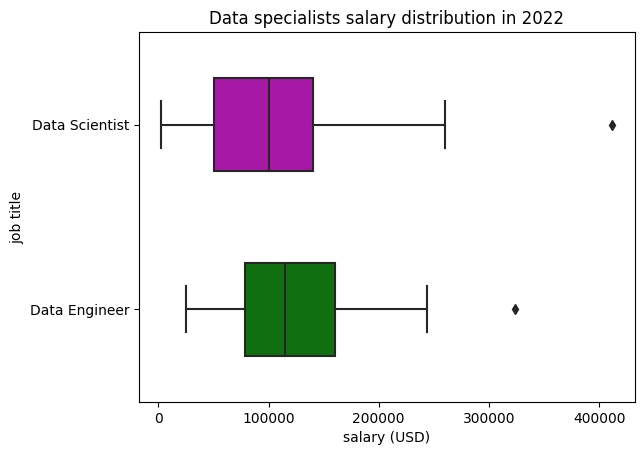

In [288]:
sal_2022 = sns.boxplot(
    df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer') & (df['work_year'] == 2022)],
    y='job_title',
    x='salary_in_usd',
    orient='h',
    palette=['m','g'],
    width=.5,
);
sal_2022.set(title='Data specialists salary distribution in 2022', xlabel='salary (USD)', ylabel='job title');

    1) в 2022 медианная з/п для позиции Data Engineer выше чем для Data Scientist
    2) учитывая больший межквартильный размах для позиции Data Scientist, можно говорить о большем диапазоне колебаний з/п в этой группе

### Соотношение зарплат специалистов Data Scientist в компаниях различных размеров

In [289]:
df.groupby('company_size')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,193.0,118213.880829,86753.270985,5882.0,60000.0,100000.0,153667.00,600000.0
M,290.0,114807.079310,60779.043553,4000.0,70821.5,109640.0,150213.75,450000.0
S,82.0,77872.097561,63814.516062,2859.0,41816.0,65511.0,100000.00,416000.0


[Text(0.5, 1.0, 'Year Salary distribution in dif company sizes')]

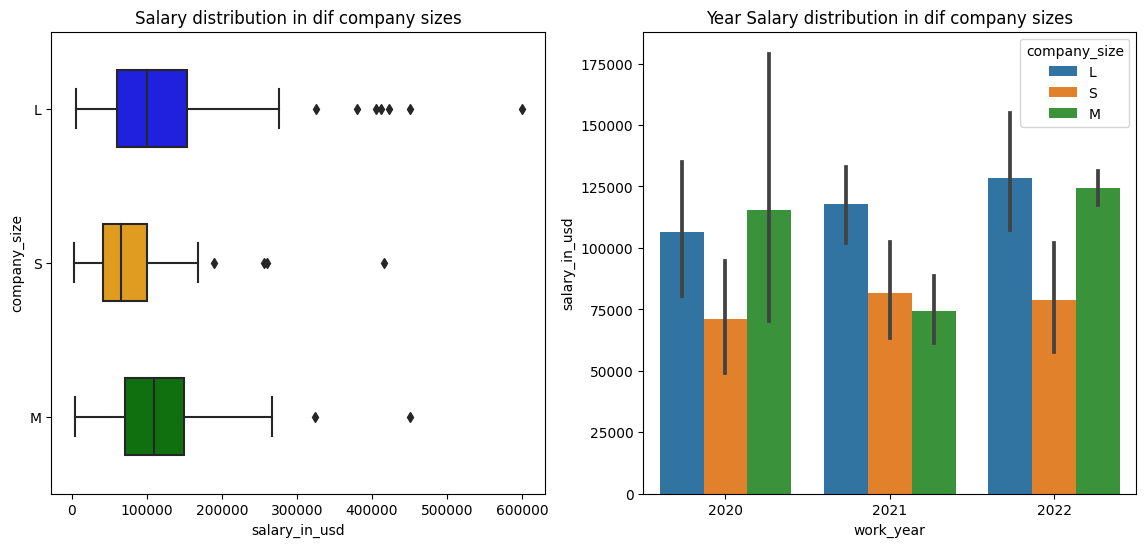

In [290]:
f,a = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

size_sal = sns.boxplot(
    df,
    y='company_size',
    x='salary_in_usd',
    ax=a[0],
    orient='h',
    palette=['b','orange','g'],
    width=.5,
)

ysize_sal = sns.barplot(
    df,
    x='work_year',
    y='salary_in_usd',
    hue='company_size',
    ax=a[1]
)

size_sal.set(title='Salary distribution in dif company sizes')
ysize_sal.set(title='Year Salary distribution in dif company sizes')

    1) медианный з/п в компаниях среднего и большого размера сопоставимы и значительно превышают уровень в компаниях малого размера
    2) наблюдается равномерный рост уровня з/п в больших компаниях в период 2020-2022
    3) наблюдается существенный рост уровня з/п в средних компаниях за период 2021-2022

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

In [291]:
df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer')].groupby(['company_size', 'job_title'])['salary_in_usd'].describe()

count           mean           std      min   
company_size job_title                                                     
L            Data Engineer    34.0   96875.617647  52008.286160  20000.0  \
             Data Scientist   43.0  102743.418605  73254.096950  13400.0   
M            Data Engineer    81.0  118369.481481  60222.079805   4000.0   
             Data Scientist   66.0  120080.575758  56347.786862   4000.0   
S            Data Engineer     6.0   66342.500000  28862.468285  33511.0   
             Data Scientist   21.0   51925.761905  33216.289638   2859.0   

                                  25%       50%        75%       max  
company_size job_title                                                
L            Data Engineer   58653.00   93141.0  112968.00  209100.0  
             Data Scientist  45240.50   90734.0  135000.00  412000.0  
M            Data Engineer   76940.00  110500.0  156600.00  324000.0  
             Data Scientist  80000.00  119529.5  157500.00  260000.0  
S            Data Engineer   47516.75   65511.0   74130.25  115000.0  
             Data Scientist  21669.00   49268.0   82500.00  105000.0

Unique positions at dataset: 50


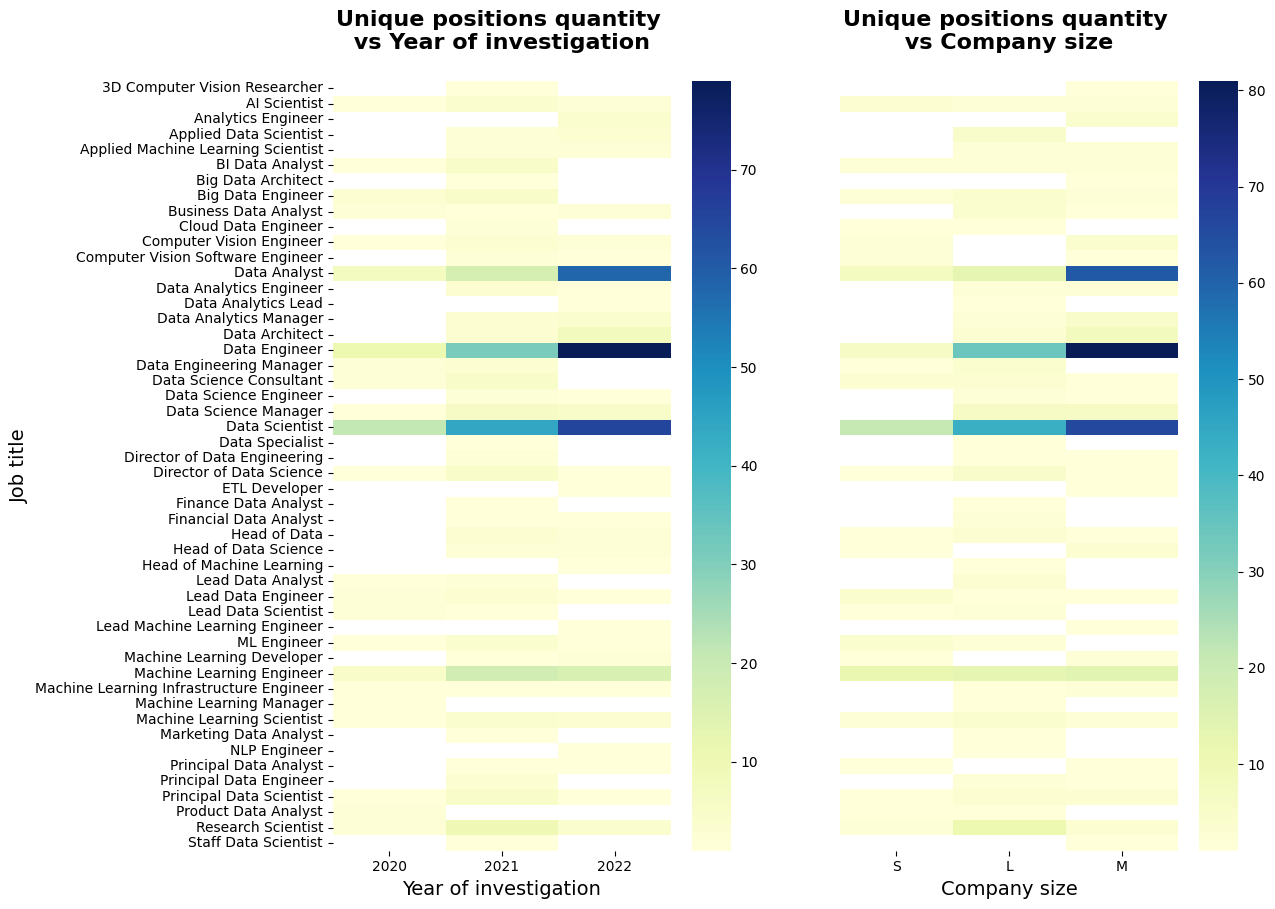

In [292]:
pivot_year = df.pivot_table(
    values='salary_in_usd',
    columns='work_year',
    index='job_title',
    aggfunc='count'
)

pivot_size = df.pivot_table(
    values='salary_in_usd',
    columns='company_size',
    index='job_title',
    aggfunc='count'
)

f,a = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

hm_year = sns.heatmap(data=pivot_year, cmap='YlGnBu', ax=a[0], annot=False)
hm_year.set_title('Unique positions quantity \n vs Year of investigation \n', fontsize=16, fontweight='bold');
hm_year.set_ylabel('Job title', fontsize=14)
hm_year.set_xlabel('Year of investigation', fontsize=14);

hm_size = sns.heatmap(data=pivot_size[['S', 'L', 'M']], cmap='YlGnBu', ax=a[1], yticklabels=False, annot=False)
hm_size.set_title('Unique positions quantity \n vs Company size \n', fontsize=16, fontweight='bold');
hm_size.set_ylabel('', fontsize=14)
hm_size.set_xlabel('Company size', fontsize=14);


print(f"Unique positions at dataset: {df['job_title'].nunique()}")

    1) максимальное количество позиций Data Engineer и Data Scientist сосредоточено в компаниях среднего размера. 
    2) в период 2020-2022 наиболее выраженна динамика роста количества позиций Data Engineer, Data Scientist, Data Analyst
    3) большее количество позиций Data Engineer относительно Data Scientist говорит об устойчивом росте спроса на этих специалистов в период 2020-2022, и повышенном спросе на эту позицию в компаниях среднего размера 

### Есть ли связь между уровнем опыта и работой удаленно

In [293]:
df_exp_rem = df.groupby(['experience_level', 'remote_ratio'])['salary_in_usd'].agg(positions_qty='count')
df_exp_rem


positions_qty
experience_level remote_ratio               
EN               0                        14
                 50                       25
                 100                      49
EX               0                         3
                 50                        5
                 100                      18
MI               0                        54
                 50                       41
                 100                     113
SE               0                        50
                 50                       27
                 100                     166

Text(0.5, 0.98, 'Positions quantitty for experience levels \n')

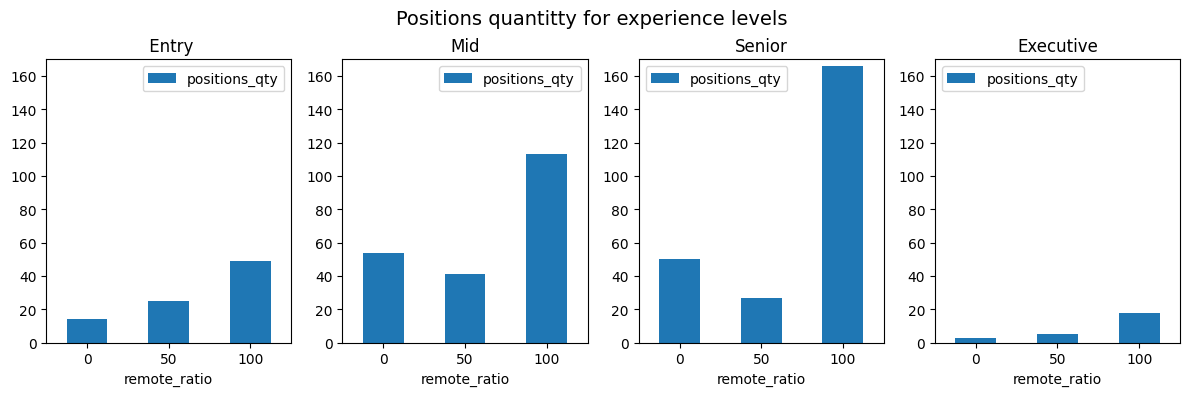

In [294]:
f,a = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
df_exp_rem.xs('EN').plot(kind='bar',ax=a[0], title='\n Entry', ylim=(None,170), rot=0)
df_exp_rem.xs('MI').plot(kind='bar',ax=a[1], title='Mid', ylim=(None,170), rot=0)
df_exp_rem.xs('SE').plot(kind='bar',ax=a[2], title='Senior', ylim=(None,170), rot=0)
df_exp_rem.xs('EX').plot(kind='bar',ax=a[3], title='Executive', ylim=(None,170), rot=0)

plt.tight_layout()
plt.legend(loc='upper left')
f.suptitle('Positions quantitty for experience levels \n', fontsize=14)

    1) во всех группах опыта преобладают специалисты, работающие удаленно
    2) группа 'Executive' характеризуется наименьшим количеством позиций во всех категориях удаленной работы.
    3) максимальное количество позиций в категории полностью удаленной работы наблюдается в группе 'Senior' и 'Mid-level'

## Статистический анализ данных

In [295]:
# set alpha
alpha = 0.05
print("p-value set for the following tests: {:.2f}".format(alpha))

def decision_normality(p):
    """The function is designed for value distribution normality decision-making

    Args:
        p (float) : statistical significance (p-value)
    """
    
    if p <= alpha:
        print('\t p-value ({:.3f}) < alpha ({:.2f}). The distribution is NOT NORMAL'.format(p,alpha))
    else:
        print('\t p-value ({:.3f}) > alpha ({:.2f}). The distribution is NORMAL'.format(p,alpha))


def decision_hypothesis(p):
    """The function is designed for H0 hypothesis decision-making

    Args:
        p (float) : statistical significance (p-value)"""
        
    if p <= alpha:
        return('p-value ({:.3f}) < alpha ({:.2f}). Reject H0'.format(p,alpha))
    else:
        print('p-value ({:.3f}) > alpha  ({:.2f}). Can not reject H0'.format(p,alpha))

p-value set for the following tests: 0.05


=================================================================================================================================================================
### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

***Statistical hypothesises***

$H_0$: з/п специалистов Data Scientist в 2022 году ($μ_1$) меньше либо равна таковой в 2021 ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

$H_1$:  з/п специалистов Data Scientist в 2022 году ($μ_1$) больше таковой в 2021($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [296]:
# form groupes for analysis
salary_2021 = df.loc[df['work_year']==2021, 'salary_in_usd']
salary_2022 = df.loc[df['work_year']==2022, 'salary_in_usd']

# normality test
print('Data scientists salary in 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Data scientists salary in 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


Data scientists salary in 2021:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL
Data scientists salary in 2022:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL


* Feature type — quantitative
* 2 groupes
* Groupes are independent
* Feature distribution is not normal

We're supposed to use <strong style='color:red'>Mann-Whitneyu</strong> test

In [297]:
# statistical test
_, p = stats.mannwhitneyu(salary_2022, salary_2021, alternative='greater')
decision_hypothesis(p)

'p-value (0.000) < alpha (0.05). Reject H0'

<span style='color:red; font-size:18px'>Статистически достоверно, что з/п специалистов DS в 2022 г выше чем в 2021<span>

<span style='color:red'>It's statistically significant that DS salary in 2022 greater than in 2021<span>

=====================================================================================================================================================================
### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


***Statistical hypothesises***

$H_0$: В 2022 году з/п Data Scientist ($μ_1$) меньше либо равна з/п Data Engineer ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

$H_1$:  В 2022 з/п Data Scientist ($μ_1$) больше з/п Data Engineer ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [298]:
# form groupes for analysis
salary_DS = df.loc[(df['job_title']=='Data Scientist') & (df['work_year']==2022), 'salary_in_usd']
salary_DE = df.loc[(df['job_title']=='Data Engineer') & (df['work_year']==2022), 'salary_in_usd']

# normality test
print('Data scientist salary in 2022:')
result = stats.shapiro(salary_DS)
decision_normality(result[1])

print('Data Engineer salary in 2022:')
result = stats.shapiro(salary_DE)
decision_normality(result[1])

Data scientist salary in 2022:
	 p-value (0.676) > alpha (0.05). The distribution is NORMAL
Data Engineer salary in 2022:
	 p-value (0.007) < alpha (0.05). The distribution is NOT NORMAL


* Feature type — quantitative
* 2 groupes
* Groupes are independent
* One of the feature distributions is not normal

We're supposed to use <strong style='color:red'>Mann-Whitneyu</strong> test

In [299]:
# statistical test
_, p = stats.mannwhitneyu(salary_DS, salary_DE, alternative='greater')
decision_hypothesis(p)

p-value (0.160) > alpha  (0.05). Can not reject H0


<span style='color:red; font-size:18px'>Нет оснований утверждать, что з/п Data scientists больше  чем Data Engineers<span>

<span style='color:red'>There is no evidence to consider that in 2022 Data scientists salary is greater than Data Engineers salary<span>

=================================================================================================================================================================
### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

***Statistical hypothesises***

$H_0$: з/п Data Scientists равны в компаниях разных размеров (S, M, L).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

$H_1$:  з/п Data Scientists не равны в компаниях разных размеров (S, M, L).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

In [300]:
# form groupes for analysis
salary_S = df.loc[df['company_size']=='S', 'salary_in_usd']
salary_M = df.loc[df['company_size']=='M', 'salary_in_usd']
salary_L = df.loc[df['company_size']=='L', 'salary_in_usd']

# normality test
print('Data scientists salary in Small companies:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Data scientists salary in Medium companies:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Data scientists salary in Large companies:')
result = stats.shapiro(salary_L)
decision_normality(result[1])

Data scientists salary in Small companies:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL
Data scientists salary in Medium companies:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL
Data scientists salary in Large companies:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL


* Feature type — quantitative
* 3 groupes
* Groupes are independent
* Feature distribution is not normal

We're supposed to use <strong style='color:red'>Kruskal-Wallis</strong> test

In [301]:
# statistical test
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

'p-value (0.000) < alpha (0.05). Reject H0'

<span style='color:red; font-size:18px'>Статистически достоверно, что з/п специалистов DS не равны в компаниях разных размеров<span>

<span style='color:red'>It's statistically significant that Data scientist salaries are not equal in different sizes companies<span>

***Statistical hypothesises***

$H_0$: з/п Data Scientists в Small-компаниях ($μ_1$) больше либо равна таковой в Large-компаниях ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

$H_1$:  з/п Data Scientists в Small-компаниях ($μ_1$) меньше чем в Large-компаниях ($μ_2$)

$$ H_1 : μ_1 < μ_2$$

* Feature type — quantitative
* 2 groupes
* Groupes are independent
* Feature distribution is not normal

We're supposed to use <strong style='color:red'>Mann-Whitneyu</strong> test

In [302]:
# statistical test
_, p = stats.mannwhitneyu(salary_S, salary_L, alternative='less')
decision_hypothesis(p)

'p-value (0.000) < alpha (0.05). Reject H0'

<span style='color:red; font-size:18px'>Статистически достоверно, что з/п специалистов DS в small-компаниях меньше чем large-компаниях<span>

<span style='color:red'>It's statistically significant that Data scientist salaries in Small-companies are less than in Large ones<span>

=================================================================================================================================================================
### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


***Statistical hypothesises***

$H_0$: Наличие позиций Data Scientists не зависит от размера компании.

$H_1$:  Наличие позиций Data Scientists и размер компании взаимосвязаны.


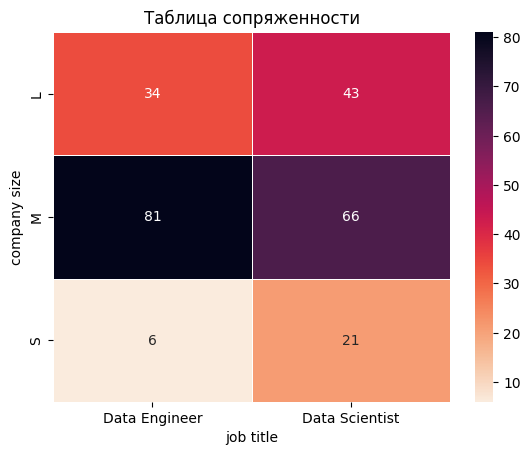

In [303]:
# form cross table
df_chi = df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer')] 

cross_table = pd.crosstab(df_chi['company_size'], df_chi['job_title'])

ax = sns.heatmap(cross_table, annot=True, linewidth=.5, fmt='.0f', cmap='rocket_r')
ax.set(xlabel='job title', ylabel='company size')
plt.title('Таблица сопряженности')
plt.show()

* Feature type — categorial
* 1 group


We're supposed to use <strong style='color:red'>Chi-squared</strong>  test (${\chi}^2$)

In [304]:
# statistical test
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

'p-value (0.005) < alpha (0.05). Reject H0'

<span style='color:red; font-size:18px'>Статистически достоверно, что наличие позиций Data Scientists и размер компании взаимосвязаны.<span>

<span style='color:red'>It's statistically significant that Data scientists positions occurence relates to company size<span>

=================================================================================================================================================================
### Как соотносятся з/п специалистов DS, главные офисы компаний которых локализованы в US, и в совокупности стран отличных от US

$H_0$: з/п специалистов Data Scientist в США ($μ_1$, company location = US) статистически меньше либо равна таковой в общей совокупности стран за исключением США ($μ_2$, company location $\neq$ US).

$$ H_0 : μ_1 <= μ_2$$

$H_1$:  з/п специалистов Data Scientist в США ($μ_1$, company location = US) статистически больше таковой в общей совокупности стран за исключением США ($μ_2$, company location $\neq$ US).

$$ H_1 : μ_1 > μ_2$$

In [305]:
# form groupes for analysis
salary_US = df.loc[df['company_location']=='US', 'salary_in_usd']
salary_noUS = df.loc[df['company_location']!='US', 'salary_in_usd']

# normality test
print('Data scientists salary in US:')
result = stats.shapiro(salary_US)
decision_normality(result[1])

print('Data scientists salary in total except US:')
result = stats.shapiro(salary_noUS)
decision_normality(result[1])


Data scientists salary in US:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL
Data scientists salary in total except US:
	 p-value (0.000) < alpha (0.05). The distribution is NOT NORMAL


* Feature type — quantitative
* 2 groupes
* Groupes are independent
* Feature distribution is not normal

We're supposed to use <strong style='color:red'>Mann-Whitneyu</strong> test

In [306]:
# statistical test
_, p = stats.mannwhitneyu(salary_US, salary_noUS, alternative='greater')
decision_hypothesis(p)

'p-value (0.000) < alpha (0.05). Reject H0'

<span style='color:red; font-size:18px'>Статистически достоверно, что з/п специалистов Data Scientist, главные офисы компаний которых локализованы в США, больше з/п в общей совокупности всех стран за исключением США<span>

<span style='color:red'>It's statistically significant that Data scientists salary in US is greater than in all company locations (in total) except US<span>

=================================================================================================================================================================
### Есть ли связь между уровнем опыта и работой удаленно

***Statistical hypothesises***

$H_0$: Опыт работы Data Scientists не связан с полностью удаленной работой (remote_ratio=100).

$H_1$:  Опыт работы Data Scientists взаимосвязан с полностью удаленной работой (remote_ratio=100).

In [307]:
ohe_encoder = ce.OneHotEncoder(cols=['remote_ratio'], use_cat_names=True) 
code_remoterat = ohe_encoder.fit_transform(df.loc[:, ['remote_ratio']])
df = pd.concat([df, code_remoterat], axis=1)

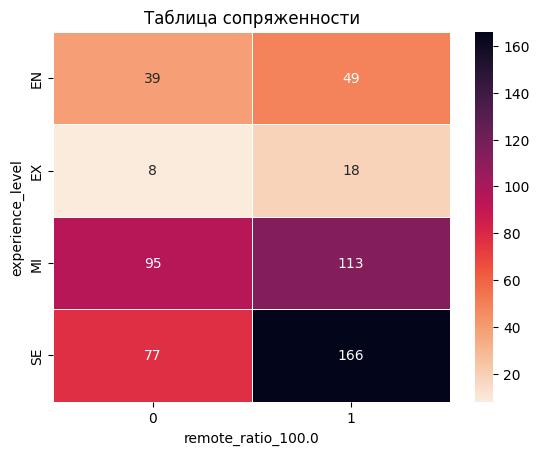

In [308]:
# form cross table
cross_tab = pd.crosstab(df['experience_level'], df['remote_ratio_100.0'])

ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap='rocket_r')
#ax.set(xlabel='job title', ylabel='company size')
plt.title('Таблица сопряженности')
plt.show()

In [309]:
# statistical test
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

'p-value (0.011) < alpha (0.05). Reject H0'

<span style='color:red; font-size:18px'>Статистически достоверно, что опыт работы Data Scientists взаимосвязан с полностью удаленной работой (remote_ratio=100)<span>

<span style='color:red'>It's statistically significant that Data scientists experience is related to remote type of job (remote_ratio = 100)<span>

## Итоговые результаты исследования

    Статистически достоверно, что з/п специалистов DS в 2022 г выше чем в 2021
    Нет оснований утверждать, что з/п Data scientists больше  чем Data Engineers
    Статистически достоверно, что з/п специалистов DS не равны в компаниях разных размеров
    Статистически достоверно, что з/п специалистов DS в small-компаниях меньше чем large-компаниях
    Статистически достоверно, что наличие позиций Data Scientists и размер компании взаимосвязаны
    Статистически достоверно, что з/п специалистов Data Scientist (гл. офис в США) больше з/п в общей совокупности всех стран кроме США
    Статистически достоверно, что опыт работы Data Scientists взаимосвязан с полностью удаленной работой (remote_ratio=100)
